# Pathway Results Analysis

This unified notebook analyzes pathway results from any subfolder within the `results/` directory.
It examines:
1. How many molecules have at least one successful pathway
2. Distribution of pathway counts across molecules
3. Pathway modality analysis (Enzymatic vs Synthetic vs PKS)
4. Summary statistics and visualizations

**Usage:** Set the `RESULTS_SUBFOLDER` variable in the configuration cell to point to your results directory.

In [1]:
import os
import re
from pathlib import Path
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

# Matplotlib plot styling
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['figure.dpi'] = 500  # Resolution of figures
plt.rcParams["figure.autolayout"] = True
plt.rcParams["legend.loc"] = 'best'
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.grid'] = False  # Remove grid lines

# For Venn diagrams
try:
    from matplotlib_venn import venn3, venn3_circles
except ImportError:
    import subprocess
    subprocess.check_call(['pip', 'install', 'matplotlib-venn'])
    from matplotlib_venn import venn3, venn3_circles

## Configuration

Set the results subfolder to analyze. This should be a folder name within the `results/` directory.

Examples:
- `"155_biomanufacturing_candidates_pathways"`
- `"kavalactone_pathways"`

In [2]:
# ============================================================================
# CONFIGURATION - Set your results subfolder here
# ============================================================================

# Available options (uncomment one):
# RESULTS_SUBFOLDER = "kavalactones_SAScore_and_SpawnRetroTideOnDatabaseCheck"
# RESULTS_SUBFOLDER = "biomanufacturing_candidates_SAScore_and_SpawnRetroTideOnDatabaseCheck"
# RESULTS_SUBFOLDER = "Roucairol_et_al_SAScore_and_SpawnRetroTideOnDatabaseCheck"
# RESULTS_SUBFOLDER = "Retro*_SAScore_and_SpawnRetroTideOnDatabaseCheck"
# RESULTS_SUBFOLDER = "V2_biomanufacturing_candidates"

RESULTS_SUBFOLDER = "V2_kavalactones"

# ============================================================================
# Derived paths (no need to modify)
# ============================================================================
RESULTS_DIR = Path(f"../results/{RESULTS_SUBFOLDER}")

# Validate the path exists
if not RESULTS_DIR.exists():
    raise FileNotFoundError(f"Results directory not found: {RESULTS_DIR}")

# Extract a friendly name for the analysis
ANALYSIS_NAME = RESULTS_SUBFOLDER.replace("_SAScore_and_SpawnRetroTideOnDatabaseCheck", "").replace("_pathways", "").replace("_", " ").title()

print(f"{'='*70}")
print(f"PATHWAY ANALYSIS: {ANALYSIS_NAME}")
print(f"{'='*70}")
print(f"\nResults directory: {RESULTS_DIR}")

PATHWAY ANALYSIS: V2 Kavalactones

Results directory: ../results/V2_kavalactones


## 1. Load and Parse Pathway Files

In [3]:
# Get all successful_pathways files
successful_pathway_files = sorted(RESULTS_DIR.glob("successful_pathways_*.txt"))
print(f"Found {len(successful_pathway_files)} successful_pathways files")

if len(successful_pathway_files) == 0:
    raise FileNotFoundError(f"No successful_pathways_*.txt files found in {RESULTS_DIR}")

Found 13 successful_pathways files


In [ ]:
def extract_molecule_name(filename: str) -> str:
    """Extract molecule name from filename.
    
    Handles various naming patterns:
    - successful_pathways_acetone_async_20260114_113246.txt -> acetone
    - successful_pathways_kavain_sequential_20260111_143548.txt -> kavain
    """
    # Remove prefix
    name = filename.replace("successful_pathways_", "")
    # Remove the async/sequential timestamp part
    name = re.sub(r"_(async|sequential)_\d{8}_\d{6}\.txt$", "", name)
    return name

def count_pathways_in_file(filepath: Path) -> int:
    """Read a successful_pathways file and extract the total pathway count."""
    with open(filepath, 'r') as f:
        content = f.read()
    
    # Look for "Total pathways: X" pattern
    match = re.search(r"Total pathways:\s*(\d+)", content)
    if match:
        return int(match.group(1))
    return 0

def parse_pathway_type_breakdown(filepath: Path) -> dict | None:
    """
    Parse the PATHWAY TYPE BREAKDOWN section from a successful_pathways.txt file.
    
    Returns a dict with pathway counts per category, or None if the section is not found.
    This uses the official tabulations from the MCTS output rather than re-parsing pathways.
    
    Returns dict with keys:
    - purely_synthetic, purely_enzymatic, synthetic_enzymatic (sink compound pathways)
    - direct_pks, synthetic_pks, enzymatic_pks, synthetic_enzymatic_pks (PKS pathways - DESIGN-BASED counts)
    - unknown (unknown/other)
    - total_pathways
    - pks_exact_designs, pks_simulated_designs (if available)
    
    Note on PKS format:
    - PKS categories have format: "Synthetic + PKS  17 pathways -> 3 entries (8 exact, 9 simulated)"
    - The design-based count (17) is extracted as the PKS pathway count
    - This represents the total number of PKS design routes, not unique pathway entries
    """
    with open(filepath, 'r') as f:
        content = f.read()
    
    # Check if this file has the PATHWAY TYPE BREAKDOWN section
    if "PATHWAY TYPE BREAKDOWN" not in content:
        return None
    
    result = {
        'purely_synthetic': 0,
        'purely_enzymatic': 0,
        'synthetic_enzymatic': 0,
        'direct_pks': 0,
        'synthetic_pks': 0,
        'enzymatic_pks': 0,
        'synthetic_enzymatic_pks': 0,
        'unknown': 0,
        'total_pathways': 0,
        'pks_exact_designs': 0,
        'pks_simulated_designs': 0,
    }
    
    # Parse total pathways
    total_match = re.search(r"Total pathways:\s*(\d+)", content)
    if total_match:
        result['total_pathways'] = int(total_match.group(1))
    
    # Patterns for sink compound categories (simple format: "Category: count")
    sink_patterns = [
        (r'Purely synthetic:\s*(\d+)', 'purely_synthetic'),
        (r'Purely enzymatic:\s*(\d+)', 'purely_enzymatic'),
        (r'Synthetic \+ enzymatic:\s*(\d+)', 'synthetic_enzymatic'),
        (r'Unknown/Other:\s*(\d+)', 'unknown'),
    ]
    
    for pattern, key in sink_patterns:
        match = re.search(pattern, content)
        if match:
            result[key] = int(match.group(1))
    
    # Patterns for PKS categories - extract DESIGN-BASED count (first number before "pathways")
    # Format: "Synthetic + PKS  17 pathways -> 3 entries (8 exact, 9 simulated)"
    # We capture 17 (design routes) not 3 (entries)
    pks_patterns = [
        # Extended format: extract design-based route count (first number before "pathways")
        (r'Direct PKS match\s+(\d+) pathways', 'direct_pks'),
        (r'Synthetic \+ PKS\s+(\d+) pathways', 'synthetic_pks'),
        (r'Enzymatic \+ PKS\s+(\d+) pathways', 'enzymatic_pks'),
        (r'Synthetic \+ enz \+ PKS\s+(\d+) pathways', 'synthetic_enzymatic_pks'),
    ]
    
    for pattern, key in pks_patterns:
        match = re.search(pattern, content)
        if match:
            result[key] = int(match.group(1))
    
    # Fallback: simple format for PKS categories (just a count, no "pathways -> entries")
    pks_simple_patterns = [
        (r'Direct PKS match\s+(\d+)\s*(?:\s|$|#)', 'direct_pks'),
        (r'Synthetic \+ PKS\s+(\d+)\s*(?:\s|$|#)', 'synthetic_pks'),
        (r'Enzymatic \+ PKS\s+(\d+)\s*(?:\s|$|#)', 'enzymatic_pks'),
        (r'Synthetic \+ enz \+ PKS\s+(\d+)\s*(?:\s|$|#)', 'synthetic_enzymatic_pks'),
    ]
    
    for pattern, key in pks_simple_patterns:
        if result[key] == 0:  # Only use fallback if not already set
            match = re.search(pattern, content)
            if match:
                result[key] = int(match.group(1))
    
    # Parse RetroTide design breakdown if available
    exact_match = re.search(r'Total exact match designs:\s*(\d+)', content)
    if exact_match:
        result['pks_exact_designs'] = int(exact_match.group(1))
    
    simulated_match = re.search(r'Total simulated designs:\s*(\d+)', content)
    if simulated_match:
        result['pks_simulated_designs'] = int(simulated_match.group(1))
    
    return result

def parse_pathways_from_file(filepath: Path) -> list[dict]:
    """
    Parse a successful_pathways file and extract modality information for each pathway.
    
    This is the FALLBACK method for older files without PATHWAY TYPE BREAKDOWN section.
    
    Returns a list of dicts with:
    - pathway_num: The pathway number
    - modalities: Set of modalities used (enzymatic, synthetic, pks)
    - depth: The depth of the pathway
    - molecule: The molecule name
    
    Modality detection:
    - enzymatic: Found via "Step N (enzymatic):" lines
    - synthetic: Found via "Step N (synthetic):" lines  
    - pks: Found via "PKS Match: Yes" or "RetroTide PKS Designs:" in pathway block
    """
    with open(filepath, 'r') as f:
        content = f.read()
    
    molecule_name = extract_molecule_name(filepath.name)
    pathways = []
    
    # Split by pathway headers
    pathway_blocks = re.split(r'PATHWAY #(\d+):', content)
    
    # Skip the header (first element) and process pairs (number, content)
    for i in range(1, len(pathway_blocks), 2):
        if i + 1 >= len(pathway_blocks):
            break
            
        pathway_num = int(pathway_blocks[i])
        pathway_content = pathway_blocks[i + 1]
        
        # Extract modalities from Step lines
        modalities = set()
        
        # Look for Step X (modality): pattern for enzymatic/synthetic
        step_matches = re.findall(r'Step \d+ \((\w+)\):', pathway_content)
        for modality in step_matches:
            modalities.add(modality.lower())
        
        # Check for PKS involvement via "PKS Match: Yes" or "RetroTide PKS Designs:" or "PKS-Synthesizable Byproducts:"
        if re.search(r'PKS Match:\s*Yes', pathway_content, re.IGNORECASE) or \
           re.search(r'RetroTide PKS Designs:', pathway_content) or \
           re.search(r'PKS-Synthesizable Byproducts:', pathway_content):
            modalities.add('pks')
        
        # Extract depth
        depth_match = re.search(r'Depth:\s*(\d+)', pathway_content)
        depth = int(depth_match.group(1)) if depth_match else 0
        
        # Handle target molecules (depth 0, no steps)
        if depth == 0 and not modalities:
            modalities.add('target')  # Special case for molecules already in sink
        
        pathways.append({
            'molecule': molecule_name,
            'pathway_num': pathway_num,
            'modalities': modalities,
            'depth': depth,
            'has_enzymatic': 'enzymatic' in modalities,
            'has_synthetic': 'synthetic' in modalities,
            'has_pks': 'pks' in modalities,
            'is_target': 'target' in modalities
        })
    
    return pathways

def get_modality_category(row):
    """Categorize pathway by which modalities it uses."""
    e = row['has_enzymatic']
    s = row['has_synthetic']
    p = row['has_pks']
    t = row['is_target']
    
    if t:
        return 'Target (no transformation)'
    elif e and s and p:
        return 'Enzymatic + Synthetic + PKS'
    elif e and s:
        return 'Enzymatic + Synthetic'
    elif e and p:
        return 'Enzymatic + PKS'
    elif s and p:
        return 'Synthetic + PKS'
    elif e:
        return 'Enzymatic only'
    elif s:
        return 'Synthetic only'
    elif p:
        return 'PKS only'
    else:
        return 'Unknown'

def breakdown_to_modality_counts(breakdown: dict) -> dict:
    """
    Convert pathway type breakdown to modality counts for Venn diagram.
    
    Maps the breakdown categories to Venn diagram values:
    - enzymatic_only: purely_enzymatic
    - synthetic_only: purely_synthetic
    - enzymatic_synthetic: synthetic_enzymatic
    - pks_only: direct_pks (design-based count)
    - enzymatic_pks: enzymatic_pks (design-based count)
    - synthetic_pks: synthetic_pks (design-based count)
    - all_three: synthetic_enzymatic_pks (design-based count)
    - target: unknown (approximation - files with breakdown don't track target separately)
    
    Note: PKS counts are design-based (total PKS design routes), not unique pathway entries.
    """
    return {
        'enzymatic_only': breakdown['purely_enzymatic'],
        'synthetic_only': breakdown['purely_synthetic'],
        'enzymatic_synthetic': breakdown['synthetic_enzymatic'],
        'pks_only': breakdown['direct_pks'],
        'enzymatic_pks': breakdown['enzymatic_pks'],
        'synthetic_pks': breakdown['synthetic_pks'],
        'all_three': breakdown['synthetic_enzymatic_pks'],
        'target': breakdown['unknown'],  # Approximation
        'pks_exact_designs': breakdown['pks_exact_designs'],
        'pks_simulated_designs': breakdown['pks_simulated_designs'],
    }

# Test on one file
test_file = successful_pathway_files[0]
print(f"Test file: {test_file.name}")
print(f"Molecule name: {extract_molecule_name(test_file.name)}")
print(f"Pathway count: {count_pathways_in_file(test_file)}")

# Test new parsing function
breakdown = parse_pathway_type_breakdown(test_file)
if breakdown:
    print(f"Has PATHWAY TYPE BREAKDOWN section: Yes")
    print(f"  Breakdown: {breakdown}")
else:
    print(f"Has PATHWAY TYPE BREAKDOWN section: No (will use fallback parsing)")

## 2. Process All Files and Generate Basic Statistics

In [5]:
# Process all files and collect basic results
results = []

for filepath in successful_pathway_files:
    molecule_name = extract_molecule_name(filepath.name)
    pathway_count = count_pathways_in_file(filepath)
    results.append({
        'molecule': molecule_name,
        'pathway_count': pathway_count,
        'has_successful_pathway': pathway_count > 0,
        'filename': filepath.name
    })

# Create DataFrame
df = pd.DataFrame(results)
print(f"Processed {len(df)} molecules")
df.head(10)

Processed 13 molecules


,molecule,pathway_count,has_successful_pathway,filename
0,10-methoxyyangonin,16905,True,successful_pathways_10-methoxyyangonin_async_2...
1,11-methoxy-12-hydroxydehydrokavain,12564,True,successful_pathways_11-methoxy-12-hydroxydehyd...
2,11-methoxyyangonin,12228,True,successful_pathways_11-methoxyyangonin_async_2...
3,5-hydroxykavain,14758,True,successful_pathways_5-hydroxykavain_async_2026...
4,56-dehydromethysticin,12264,True,successful_pathways_56-dehydromethysticin_asyn...
5,56-dihydroyangonin,10309,True,successful_pathways_56-dihydroyangonin_async_2...
6,5678-tetrahydroyangonin,6770,True,successful_pathways_5678-tetrahydroyangonin_as...
7,78-dihydrokavain,8392,True,successful_pathways_78-dihydrokavain_async_202...
8,78-dihydroyangonin,6933,True,successful_pathways_78-dihydroyangonin_async_2...
9,Desmethoxyyangonin,13604,True,successful_pathways_Desmethoxyyangonin_async_2...


In [6]:
# Summary Statistics
print("="*70)
print(f"SUMMARY: {ANALYSIS_NAME.upper()} PATHWAY ANALYSIS")
print("="*70)

total_molecules = len(df)
molecules_with_pathways = df['has_successful_pathway'].sum()
molecules_without_pathways = total_molecules - molecules_with_pathways

print(f"\nTotal molecules analyzed: {total_molecules}")
print(f"Molecules with at least 1 successful pathway: {molecules_with_pathways} ({100*molecules_with_pathways/total_molecules:.1f}%)")
print(f"Molecules with NO successful pathway: {molecules_without_pathways} ({100*molecules_without_pathways/total_molecules:.1f}%)")

print(f"\n--- Pathway Count Statistics ---")
print(f"Mean pathways per molecule: {df['pathway_count'].mean():.2f}")
print(f"Median pathways per molecule: {df['pathway_count'].median():.0f}")
print(f"Max pathways for a single molecule: {df['pathway_count'].max()}")
print(f"Min pathways for a single molecule: {df['pathway_count'].min()}")
print(f"Total pathways across all molecules: {df['pathway_count'].sum()}")

SUMMARY: V2 KAVALACTONES PATHWAY ANALYSIS

Total molecules analyzed: 13
Molecules with at least 1 successful pathway: 13 (100.0%)
Molecules with NO successful pathway: 0 (0.0%)

--- Pathway Count Statistics ---
Mean pathways per molecule: 11321.92
Median pathways per molecule: 12228
Max pathways for a single molecule: 16905
Min pathways for a single molecule: 6770
Total pathways across all molecules: 147185


In [7]:
# Show molecules WITHOUT any successful pathways
no_pathway_df = df[~df['has_successful_pathway']].copy()
print(f"\nMolecules with NO successful pathway ({len(no_pathway_df)}):")
print("-"*50)
if len(no_pathway_df) > 0:
    for idx, row in no_pathway_df.iterrows():
        print(f"  - {row['molecule']}")
else:
    print("  All molecules have at least one successful pathway!")


Molecules with NO successful pathway (0):
--------------------------------------------------
  All molecules have at least one successful pathway!


In [8]:
# Show top 20 molecules by pathway count
print("\nTop 20 molecules by number of successful pathways:")
print("-"*50)
top_n = min(20, len(df))
top_molecules = df.nlargest(top_n, 'pathway_count')[['molecule', 'pathway_count']]
for idx, (_, row) in enumerate(top_molecules.iterrows(), 1):
    print(f"  {idx:2d}. {row['molecule']}: {row['pathway_count']} pathways")


Top 20 molecules by number of successful pathways:
--------------------------------------------------
   1. 10-methoxyyangonin: 16905 pathways
   2. 5-hydroxykavain: 14758 pathways
   3. Desmethoxyyangonin: 13604 pathways
   4. Methysticin: 13328 pathways
   5. 11-methoxy-12-hydroxydehydrokavain: 12564 pathways
   6. 56-dehydromethysticin: 12264 pathways
   7. 11-methoxyyangonin: 12228 pathways
   8. Yangonin: 10608 pathways
   9. 56-dihydroyangonin: 10309 pathways
  10. Kavain: 8522 pathways
  11. 78-dihydrokavain: 8392 pathways
  12. 78-dihydroyangonin: 6933 pathways
  13. 5678-tetrahydroyangonin: 6770 pathways


In [9]:
# Distribution of pathway counts
print("\nDistribution of pathway counts:")
print("-"*50)

bins = [0, 1, 10, 50, 100, 200, 500, float('inf')]
labels = ['0', '1-9', '10-49', '50-99', '100-199', '200-499', '500+']

df['pathway_bin'] = pd.cut(df['pathway_count'], bins=bins, labels=labels, right=False)
distribution = df['pathway_bin'].value_counts().sort_index()

for bin_label, count in distribution.items():
    pct = 100 * count / len(df)
    bar = '█' * int(pct / 2)
    print(f"  {bin_label:>8} pathways: {count:3d} molecules ({pct:5.1f}%) {bar}")


Distribution of pathway counts:
--------------------------------------------------
         0 pathways:   0 molecules (  0.0%) 
       1-9 pathways:   0 molecules (  0.0%) 
     10-49 pathways:   0 molecules (  0.0%) 
     50-99 pathways:   0 molecules (  0.0%) 
   100-199 pathways:   0 molecules (  0.0%) 
   200-499 pathways:   0 molecules (  0.0%) 
      500+ pathways:  13 molecules (100.0%) ██████████████████████████████████████████████████


## 3. Pathway Modality Analysis: Enzymatic vs Synthetic vs PKS

Analyze what synthesis modalities are used in each pathway to understand the distribution across:
- Enzymatic only
- Synthetic chemistry only  
- PKS only
- Enzymatic + Synthetic
- Enzymatic + PKS
- Synthetic + PKS
- All three modalities

**Note:** When files contain a `PATHWAY TYPE BREAKDOWN` section (from newer MCTS runs), 
the official tabulations are used directly. For older files without this section, 
modality counts are computed by parsing individual pathways.

In [10]:
# Parse all pathway files and collect modality data
# Use PATHWAY TYPE BREAKDOWN section when available, fallback to individual pathway parsing

all_pathways = []  # For per-pathway data (needed for per-molecule analysis)
aggregated_counts = {
    'enzymatic_only': 0,
    'synthetic_only': 0,
    'enzymatic_synthetic': 0,
    'pks_only': 0,
    'enzymatic_pks': 0,
    'synthetic_pks': 0,
    'all_three': 0,
    'target': 0,
    'pks_exact_designs': 0,
    'pks_simulated_designs': 0,
}

files_with_breakdown = 0
files_without_breakdown = 0

for filepath in successful_pathway_files:
    # Try to parse using the new PATHWAY TYPE BREAKDOWN section
    breakdown = parse_pathway_type_breakdown(filepath)
    
    if breakdown:
        files_with_breakdown += 1
        # Use the official tabulations
        counts = breakdown_to_modality_counts(breakdown)
        for key in aggregated_counts:
            aggregated_counts[key] += counts.get(key, 0)
    else:
        files_without_breakdown += 1
    
    # Always parse individual pathways for per-molecule analysis
    # (needed for detailed modality access per molecule)
    pathways = parse_pathways_from_file(filepath)
    all_pathways.extend(pathways)

print(f"Files with PATHWAY TYPE BREAKDOWN section: {files_with_breakdown}")
print(f"Files without (using fallback parsing): {files_without_breakdown}")
print(f"\nTotal pathways parsed: {len(all_pathways)}")

# Create DataFrame for per-pathway analysis
pathways_df = pd.DataFrame(all_pathways)
print(f"DataFrame shape: {pathways_df.shape}")

# Show aggregated counts from tabulations (if any files had them)
if files_with_breakdown > 0:
    print(f"\n--- Aggregated Counts from Tabulations ---")
    for key, count in aggregated_counts.items():
        if not key.startswith('pks_'):  # Skip PKS design counts for now
            print(f"  {key}: {count}")
    print(f"\n  PKS exact designs: {aggregated_counts['pks_exact_designs']}")
    print(f"  PKS simulated designs: {aggregated_counts['pks_simulated_designs']}")

pathways_df.head(10)

Files with PATHWAY TYPE BREAKDOWN section: 13
Files without (using fallback parsing): 0

Total pathways parsed: 147185
DataFrame shape: (147185, 8)

--- Aggregated Counts from Tabulations ---
  enzymatic_only: 18617
  synthetic_only: 36796
  enzymatic_synthetic: 91621
  enzymatic_pks: 0
  synthetic_pks: 113
  all_three: 25
  target: 13

  PKS exact designs: 155
  PKS simulated designs: 306


,molecule,pathway_num,modalities,depth,has_enzymatic,has_synthetic,has_pks,is_target
0,10-methoxyyangonin,1,{pks},0,False,False,True,False
1,10-methoxyyangonin,2,"{pks, enzymatic}",1,True,False,True,False
2,10-methoxyyangonin,3,"{pks, enzymatic}",1,True,False,True,False
3,10-methoxyyangonin,4,"{pks, enzymatic}",1,True,False,True,False
4,10-methoxyyangonin,5,"{pks, enzymatic}",1,True,False,True,False
5,10-methoxyyangonin,6,"{pks, enzymatic}",1,True,False,True,False
6,10-methoxyyangonin,7,"{pks, enzymatic}",1,True,False,True,False
7,10-methoxyyangonin,8,"{pks, enzymatic}",1,True,False,True,False
8,10-methoxyyangonin,9,"{pks, enzymatic}",1,True,False,True,False
9,10-methoxyyangonin,10,"{pks, enzymatic}",1,True,False,True,False


In [11]:
# Create modality categories (always compute from pathways_df for per-pathway DataFrame)
pathways_df['modality_category'] = pathways_df.apply(get_modality_category, axis=1)

# Count by category (from pathway parsing, for compatibility)
category_counts = pathways_df['modality_category'].value_counts()

print("="*70)
print("PATHWAY MODALITY DISTRIBUTION")
print("="*70)

# Calculate total from official tabulations if available
if files_with_breakdown > 0:
    # Use aggregated_counts dict (defined in previous cell)
    total_pathways_tabulated = (aggregated_counts['enzymatic_only'] + aggregated_counts['synthetic_only'] + 
                                 aggregated_counts['enzymatic_synthetic'] + aggregated_counts['pks_only'] + 
                                 aggregated_counts['enzymatic_pks'] + aggregated_counts['synthetic_pks'] + 
                                 aggregated_counts['all_three'] + aggregated_counts['target'])
    print(f"\nTotal pathways (from tabulations): {total_pathways_tabulated}")
    print(f"Total pathways (from parsing): {len(pathways_df)}")
    
    # Use tabulated counts for display
    print(f"\nBreakdown by modality combination (from official tabulations):")
    print("-"*50)
    
    display_order = [
        ('Enzymatic + Synthetic', aggregated_counts['enzymatic_synthetic']),
        ('Synthetic only', aggregated_counts['synthetic_only']),
        ('Enzymatic only', aggregated_counts['enzymatic_only']),
        ('Enzymatic + PKS', aggregated_counts['enzymatic_pks']),
        ('Synthetic + PKS', aggregated_counts['synthetic_pks']),
        ('Enzymatic + Synthetic + PKS', aggregated_counts['all_three']),
        ('PKS only', aggregated_counts['pks_only']),
        ('Target (no transformation)', aggregated_counts['target']),
    ]
    
    total_for_pct = total_pathways_tabulated if total_pathways_tabulated > 0 else 1
    for category, count in display_order:
        if count > 0:
            pct = 100 * count / total_for_pct
            bar = '█' * int(pct / 2)
            print(f"  {category:30s}: {count:6d} ({pct:5.1f}%) {bar}")
else:
    print(f"\nTotal pathways: {len(pathways_df)}")
    print(f"\nBreakdown by modality combination (from pathway parsing):")
    print("-"*50)
    
    for category, count in category_counts.items():
        pct = 100 * count / len(pathways_df) if len(pathways_df) > 0 else 0
        bar = '█' * int(pct / 2)
        print(f"  {category:30s}: {count:6d} ({pct:5.1f}%) {bar}")

PATHWAY MODALITY DISTRIBUTION

Total pathways (from tabulations): 147185
Total pathways (from parsing): 147185

Breakdown by modality combination (from official tabulations):
--------------------------------------------------
  Enzymatic + Synthetic         :  91621 ( 62.2%) ███████████████████████████████
  Synthetic only                :  36796 ( 25.0%) ████████████
  Enzymatic only                :  18617 ( 12.6%) ██████
  Synthetic + PKS               :    113 (  0.1%) 
  Enzymatic + Synthetic + PKS   :     25 (  0.0%) 
  Target (no transformation)    :     13 (  0.0%) 


In [12]:
# Calculate Venn diagram values
# Use aggregated counts from tabulations if available, otherwise compute from pathways_df

if files_with_breakdown > 0:
    # Use official tabulations (more accurate)
    print("Using aggregated counts from PATHWAY TYPE BREAKDOWN sections")
    enzymatic_only = aggregated_counts['enzymatic_only']
    synthetic_only = aggregated_counts['synthetic_only']
    enzymatic_synthetic = aggregated_counts['enzymatic_synthetic']
    pks_only = aggregated_counts['pks_only']
    enzymatic_pks = aggregated_counts['enzymatic_pks']
    synthetic_pks = aggregated_counts['synthetic_pks']
    all_three = aggregated_counts['all_three']
    target_count = aggregated_counts['target']
    
    # PKS design counts
    pks_exact_designs = aggregated_counts['pks_exact_designs']
    pks_simulated_designs = aggregated_counts['pks_simulated_designs']
else:
    # Fallback: compute from individual pathway parsing
    print("Computing counts from individual pathway parsing (fallback mode)")
    non_target_df = pathways_df[~pathways_df['is_target']]
    
    enzymatic_only = len(non_target_df[(non_target_df['has_enzymatic']) & 
                                        (~non_target_df['has_synthetic']) & 
                                        (~non_target_df['has_pks'])])
    
    synthetic_only = len(non_target_df[(~non_target_df['has_enzymatic']) & 
                                        (non_target_df['has_synthetic']) & 
                                        (~non_target_df['has_pks'])])
    
    pks_only = len(non_target_df[(~non_target_df['has_enzymatic']) & 
                                  (~non_target_df['has_synthetic']) & 
                                  (non_target_df['has_pks'])])
    
    enzymatic_synthetic = len(non_target_df[(non_target_df['has_enzymatic']) & 
                                             (non_target_df['has_synthetic']) & 
                                             (~non_target_df['has_pks'])])
    
    enzymatic_pks = len(non_target_df[(non_target_df['has_enzymatic']) & 
                                       (~non_target_df['has_synthetic']) & 
                                       (non_target_df['has_pks'])])
    
    synthetic_pks = len(non_target_df[(~non_target_df['has_enzymatic']) & 
                                       (non_target_df['has_synthetic']) & 
                                       (non_target_df['has_pks'])])
    
    all_three = len(non_target_df[(non_target_df['has_enzymatic']) & 
                                   (non_target_df['has_synthetic']) & 
                                   (non_target_df['has_pks'])])
    
    target_count = len(pathways_df[pathways_df['is_target']])
    pks_exact_designs = 0
    pks_simulated_designs = 0

print("\nVenn Diagram Values:")
print(f"  Enzymatic only: {enzymatic_only}")
print(f"  Synthetic only: {synthetic_only}")
print(f"  PKS only: {pks_only}")
print(f"  Enzymatic + Synthetic: {enzymatic_synthetic}")
print(f"  Enzymatic + PKS: {enzymatic_pks}")
print(f"  Synthetic + PKS: {synthetic_pks}")
print(f"  All three: {all_three}")
print(f"  Target (no transformation): {target_count}")

if pks_exact_designs > 0 or pks_simulated_designs > 0:
    print(f"\nPKS Design Counts:")
    print(f"  Exact match designs: {pks_exact_designs}")
    print(f"  Simulated designs: {pks_simulated_designs}")
    print(f"  Total PKS designs: {pks_exact_designs + pks_simulated_designs}")

Using aggregated counts from PATHWAY TYPE BREAKDOWN sections

Venn Diagram Values:
  Enzymatic only: 18617
  Synthetic only: 36796
  PKS only: 0
  Enzymatic + Synthetic: 91621
  Enzymatic + PKS: 0
  Synthetic + PKS: 113
  All three: 25
  Target (no transformation): 13

PKS Design Counts:
  Exact match designs: 155
  Simulated designs: 306
  Total PKS designs: 461


Venn diagram saved to: ../results/V2_kavalactones/pathway_modality_venn_diagram.png


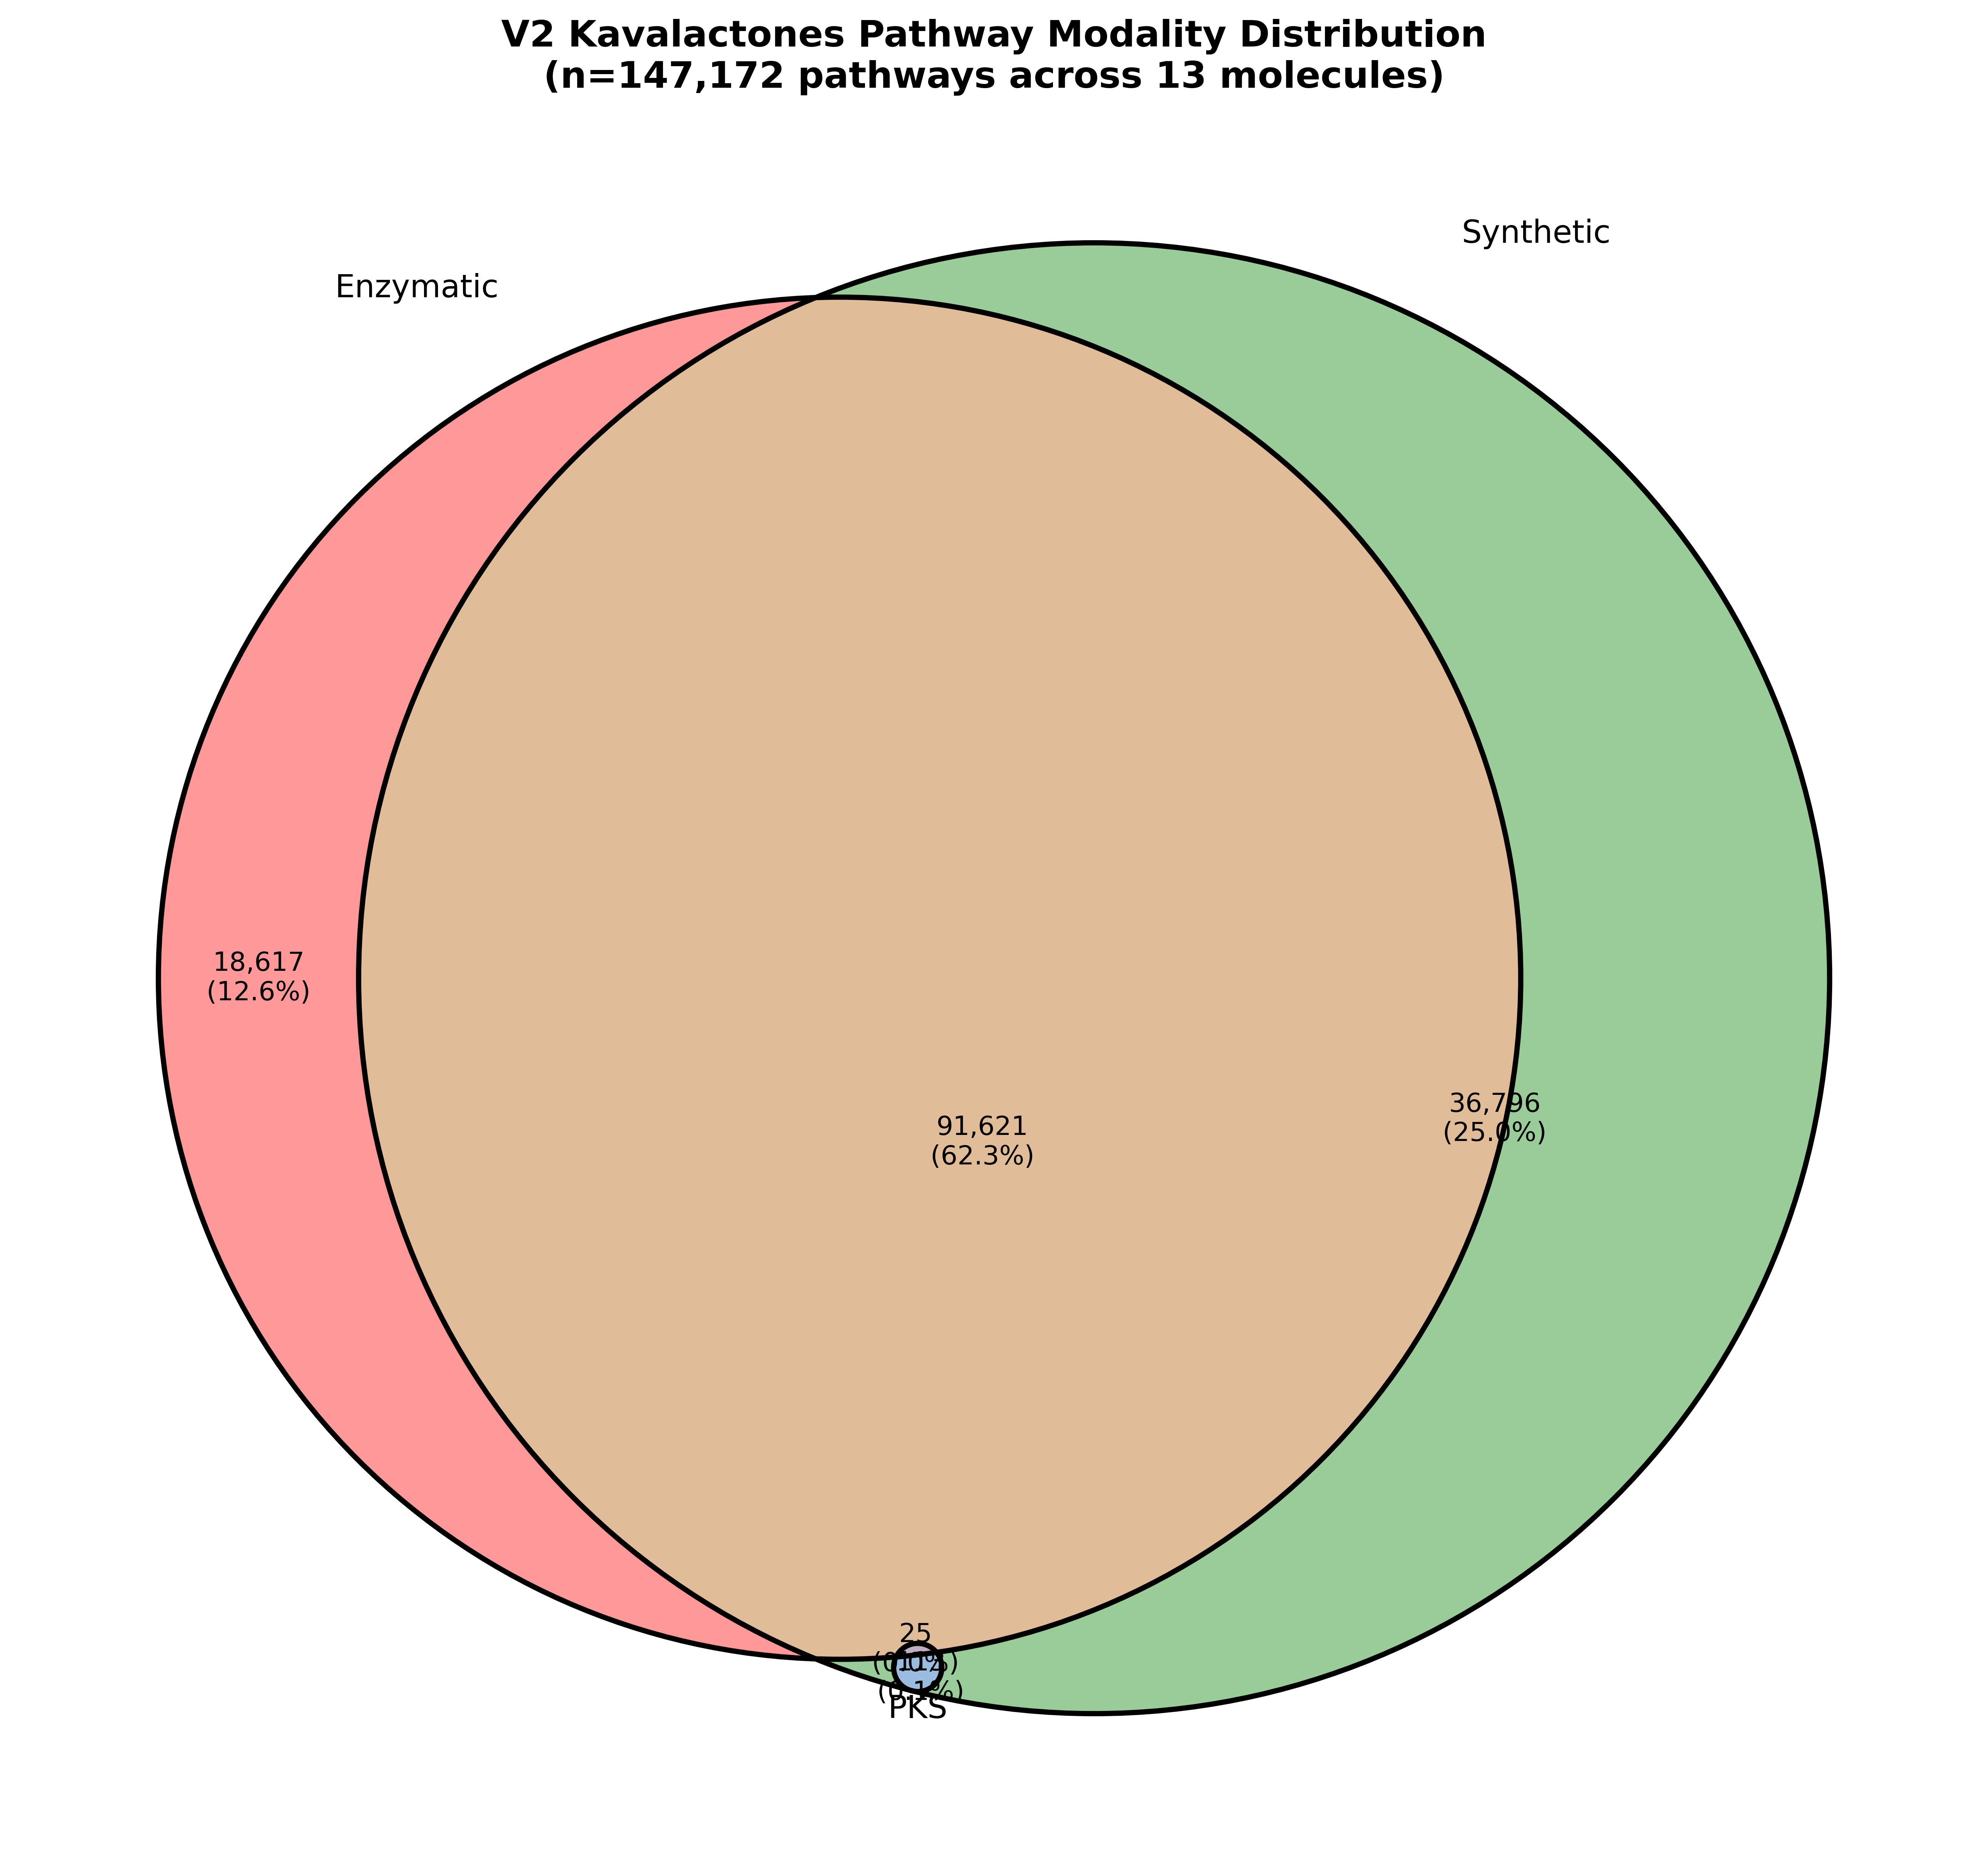

In [13]:
# Create Venn diagram
fig, ax = plt.subplots(figsize=(12, 10))

# venn3 takes subsets in order: (100, 010, 110, 001, 101, 011, 111)
subsets = (enzymatic_only, synthetic_only, enzymatic_synthetic, 
           pks_only, enzymatic_pks, synthetic_pks, all_three)

v = venn3(subsets=subsets, 
          set_labels=('Enzymatic', 'Synthetic', 'PKS'),
          ax=ax)

# Calculate total pathways for percentages (excluding target/unknown)
total_pathways_for_venn = (enzymatic_only + synthetic_only + enzymatic_synthetic + 
                           pks_only + enzymatic_pks + synthetic_pks + all_three)

# Style the diagram with percentages
if total_pathways_for_venn > 0:
    if v.get_label_by_id('100'):
        v.get_label_by_id('100').set_text(f'{enzymatic_only:,}\n({100*enzymatic_only/total_pathways_for_venn:.1f}%)')
    if v.get_label_by_id('010'):
        v.get_label_by_id('010').set_text(f'{synthetic_only:,}\n({100*synthetic_only/total_pathways_for_venn:.1f}%)')
    if v.get_label_by_id('110'):
        v.get_label_by_id('110').set_text(f'{enzymatic_synthetic:,}\n({100*enzymatic_synthetic/total_pathways_for_venn:.1f}%)')
    if v.get_label_by_id('001') and pks_only > 0:
        v.get_label_by_id('001').set_text(f'{pks_only:,}\n({100*pks_only/total_pathways_for_venn:.1f}%)')
    if v.get_label_by_id('101') and enzymatic_pks > 0:
        v.get_label_by_id('101').set_text(f'{enzymatic_pks:,}\n({100*enzymatic_pks/total_pathways_for_venn:.1f}%)')
    if v.get_label_by_id('011') and synthetic_pks > 0:
        v.get_label_by_id('011').set_text(f'{synthetic_pks:,}\n({100*synthetic_pks/total_pathways_for_venn:.1f}%)')
    if v.get_label_by_id('111') and all_three > 0:
        v.get_label_by_id('111').set_text(f'{all_three:,}\n({100*all_three/total_pathways_for_venn:.1f}%)')

plt.title(f'{ANALYSIS_NAME} Pathway Modality Distribution\n(n={total_pathways_for_venn:,} pathways across {len(df)} molecules)', 
          fontsize=14, fontweight='bold')
venn3_circles(subsets=subsets, ax=ax)

plt.tight_layout()
venn_path = RESULTS_DIR / 'pathway_modality_venn_diagram.png'
plt.savefig(venn_path, dpi=300, bbox_inches='tight')
print(f"Venn diagram saved to: {venn_path}")
plt.show()

Charts saved to: ../results/V2_kavalactones/pathway_modality_charts.png


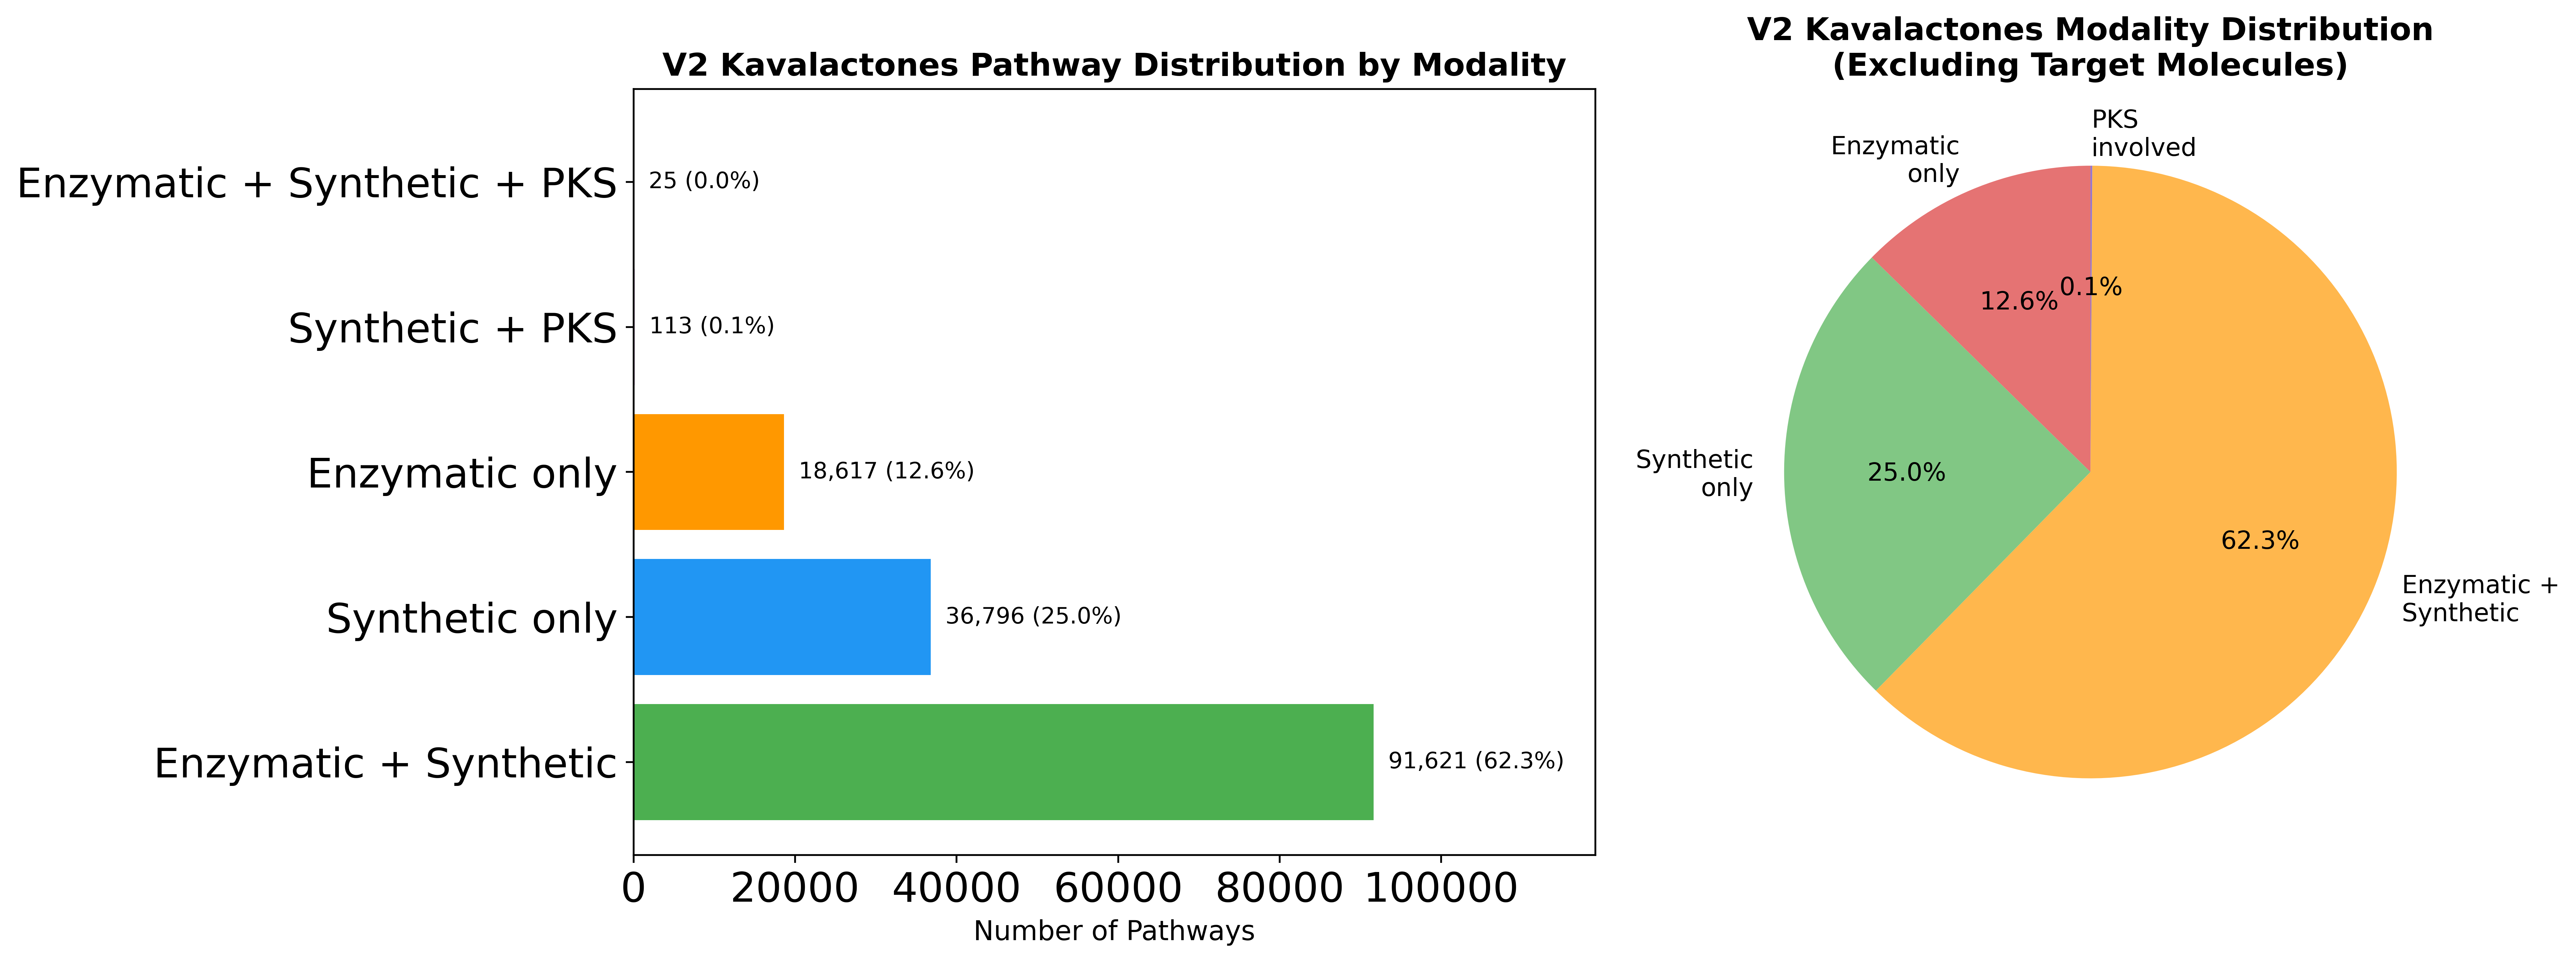


MODALITY SUMMARY STATISTICS

Total pathways (excluding target molecules): 147,172

Pathways involving enzymatic reactions: 110,263 (74.9%)
Pathways involving synthetic chemistry: 128,555 (87.4%)
Pathways involving PKS: 138 (0.1%)

--- PKS Design Breakdown ---
Exact match designs: 155
Simulated designs: 306
Total PKS designs: 461


In [14]:
# Create bar and pie charts
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Calculate total for non-target pathways
total_non_target = (enzymatic_only + synthetic_only + enzymatic_synthetic + 
                    pks_only + enzymatic_pks + synthetic_pks + all_three)

# Bar chart of modality categories - use tabulated data if available
ax1 = axes[0]

# Build ordered categories and counts
bar_data = [
    ('Enzymatic + Synthetic', enzymatic_synthetic),
    ('Synthetic only', synthetic_only),
    ('Enzymatic only', enzymatic_only),
    ('Enzymatic + PKS', enzymatic_pks),
    ('Synthetic + PKS', synthetic_pks),
    ('Enzymatic + Synthetic + PKS', all_three),
    ('PKS only', pks_only),
]

# Filter out zero counts
bar_data = [(cat, count) for cat, count in bar_data if count > 0]
categories = [cat for cat, _ in bar_data]
counts = [count for _, count in bar_data]

colors = ['#4CAF50', '#2196F3', '#FF9800', '#9C27B0', '#F44336', '#00BCD4', '#795548', '#607D8B']

bars = ax1.barh(categories, counts, color=colors[:len(categories)])
ax1.set_xlabel('Number of Pathways', fontsize=12)
ax1.set_title(f'{ANALYSIS_NAME} Pathway Distribution by Modality', fontsize=14, fontweight='bold')

# Add count labels on bars
for bar, count in zip(bars, counts):
    pct = 100 * count / sum(counts) if sum(counts) > 0 else 0
    ax1.text(bar.get_width() + max(counts)*0.02, bar.get_y() + bar.get_height()/2, 
             f'{count:,} ({pct:.1f}%)', va='center', fontsize=10)

ax1.set_xlim(0, max(counts) * 1.3 if counts else 1)

# Pie chart showing simplified breakdown
ax2 = axes[1]
pie_data = [enzymatic_only, synthetic_only, enzymatic_synthetic]
pie_labels = ['Enzymatic\nonly', 'Synthetic\nonly', 'Enzymatic +\nSynthetic']
pie_colors = ['#E57373', '#81C784', '#FFB74D']

# Add PKS if present
pks_total = pks_only + enzymatic_pks + synthetic_pks + all_three
if pks_total > 0:
    pie_data.append(pks_total)
    pie_labels.append('PKS\ninvolved')
    pie_colors.append('#9575CD')

# Filter out zeros for pie chart
pie_filtered = [(d, l, c) for d, l, c in zip(pie_data, pie_labels, pie_colors) if d > 0]
if pie_filtered:
    pie_data, pie_labels, pie_colors = zip(*pie_filtered)
    wedges, texts, autotexts = ax2.pie(pie_data, labels=pie_labels, autopct='%1.1f%%', 
                                        colors=pie_colors, startangle=90, 
                                        textprops={'fontsize': 11})
ax2.set_title(f'{ANALYSIS_NAME} Modality Distribution\n(Excluding Target Molecules)', 
              fontsize=14, fontweight='bold')

plt.tight_layout()
charts_path = RESULTS_DIR / 'pathway_modality_charts.png'
plt.savefig(charts_path, dpi=300, bbox_inches='tight')
print(f"Charts saved to: {charts_path}")
plt.show()

# Print summary statistics
print("\n" + "="*70)
print("MODALITY SUMMARY STATISTICS")
print("="*70)
print(f"\nTotal pathways (excluding target molecules): {total_non_target:,}")
print(f"\nPathways involving enzymatic reactions: {enzymatic_only + enzymatic_synthetic + enzymatic_pks + all_three:,} ({100*(enzymatic_only + enzymatic_synthetic + enzymatic_pks + all_three)/total_non_target:.1f}%)" if total_non_target > 0 else "")
print(f"Pathways involving synthetic chemistry: {synthetic_only + enzymatic_synthetic + synthetic_pks + all_three:,} ({100*(synthetic_only + enzymatic_synthetic + synthetic_pks + all_three)/total_non_target:.1f}%)" if total_non_target > 0 else "")
print(f"Pathways involving PKS: {pks_only + enzymatic_pks + synthetic_pks + all_three:,} ({100*(pks_only + enzymatic_pks + synthetic_pks + all_three)/total_non_target:.1f}%)" if total_non_target > 0 else "")

# Show PKS design breakdown if available
if pks_exact_designs > 0 or pks_simulated_designs > 0:
    print(f"\n--- PKS Design Breakdown ---")
    print(f"Exact match designs: {pks_exact_designs}")
    print(f"Simulated designs: {pks_simulated_designs}")
    print(f"Total PKS designs: {pks_exact_designs + pks_simulated_designs}")

## 4. Per-Molecule Modality Analysis

In [15]:
# Per-molecule analysis: what modalities does each molecule have access to?
molecule_modalities = pathways_df.groupby('molecule').agg({
    'has_enzymatic': 'any',
    'has_synthetic': 'any', 
    'has_pks': 'any',
    'pathway_num': 'count'
}).rename(columns={'pathway_num': 'total_pathways'})

# Count molecules by their available modalities
molecules_with_enz_only = len(molecule_modalities[(molecule_modalities['has_enzymatic']) & 
                                                    (~molecule_modalities['has_synthetic']) & 
                                                    (~molecule_modalities['has_pks'])])

molecules_with_syn_only = len(molecule_modalities[(~molecule_modalities['has_enzymatic']) & 
                                                    (molecule_modalities['has_synthetic']) & 
                                                    (~molecule_modalities['has_pks'])])

molecules_with_pks = len(molecule_modalities[molecule_modalities['has_pks']])
molecules_with_both = len(molecule_modalities[(molecule_modalities['has_enzymatic']) & 
                                               (molecule_modalities['has_synthetic'])])

print("="*70)
print("PER-MOLECULE MODALITY ACCESS")
print("="*70)
print(f"\nTotal molecules analyzed: {len(molecule_modalities)}")
print(f"\nMolecules with at least one enzymatic pathway: {molecule_modalities['has_enzymatic'].sum()}")
print(f"Molecules with at least one synthetic pathway: {molecule_modalities['has_synthetic'].sum()}")
print(f"Molecules with at least one PKS pathway: {molecule_modalities['has_pks'].sum()}")

print(f"\n--- Exclusive Access ---")
print(f"Molecules with ONLY enzymatic pathways: {molecules_with_enz_only}")
print(f"Molecules with ONLY synthetic pathways: {molecules_with_syn_only}")
print(f"Molecules accessible via BOTH enzymatic AND synthetic: {molecules_with_both}")

# List molecules with exclusive access
if molecules_with_syn_only > 0:
    syn_only_molecules = molecule_modalities[(~molecule_modalities['has_enzymatic']) & 
                                              (molecule_modalities['has_synthetic']) & 
                                              (~molecule_modalities['has_pks'])].index.tolist()
    print(f"\nMolecules accessible ONLY via synthetic chemistry ({len(syn_only_molecules)}):")
    for mol in syn_only_molecules:
        count = molecule_modalities.loc[mol, 'total_pathways']
        print(f"  - {mol} ({count} pathways)")

if molecules_with_enz_only > 0:
    enz_only_molecules = molecule_modalities[(molecule_modalities['has_enzymatic']) & 
                                              (~molecule_modalities['has_synthetic']) & 
                                              (~molecule_modalities['has_pks'])].index.tolist()
    print(f"\nMolecules accessible ONLY via enzymatic reactions ({len(enz_only_molecules)}):")
    for mol in enz_only_molecules:
        count = molecule_modalities.loc[mol, 'total_pathways']
        print(f"  - {mol} ({count} pathways)")

PER-MOLECULE MODALITY ACCESS

Total molecules analyzed: 13

Molecules with at least one enzymatic pathway: 13
Molecules with at least one synthetic pathway: 13
Molecules with at least one PKS pathway: 13

--- Exclusive Access ---
Molecules with ONLY enzymatic pathways: 0
Molecules with ONLY synthetic pathways: 0
Molecules accessible via BOTH enzymatic AND synthetic: 13


In [16]:
# Per-molecule detailed modality access
print("\n--- Detailed Modality Access per Molecule ---")
for mol, row in molecule_modalities.iterrows():
    modalities = []
    if row['has_enzymatic']:
        modalities.append('Enz')
    if row['has_synthetic']:
        modalities.append('Syn')
    if row['has_pks']:
        modalities.append('PKS')
    mod_str = '+'.join(modalities) if modalities else 'None'
    print(f"  {mol}: {row['total_pathways']} pathways [{mod_str}]")


--- Detailed Modality Access per Molecule ---
  10-methoxyyangonin: 16905 pathways [Enz+Syn+PKS]
  11-methoxy-12-hydroxydehydrokavain: 12564 pathways [Enz+Syn+PKS]
  11-methoxyyangonin: 12228 pathways [Enz+Syn+PKS]
  5-hydroxykavain: 14758 pathways [Enz+Syn+PKS]
  56-dehydromethysticin: 12264 pathways [Enz+Syn+PKS]
  56-dihydroyangonin: 10309 pathways [Enz+Syn+PKS]
  5678-tetrahydroyangonin: 6770 pathways [Enz+Syn+PKS]
  78-dihydrokavain: 8392 pathways [Enz+Syn+PKS]
  78-dihydroyangonin: 6933 pathways [Enz+Syn+PKS]
  Desmethoxyyangonin: 13604 pathways [Enz+Syn+PKS]
  Kavain: 8522 pathways [Enz+Syn+PKS]
  Methysticin: 13328 pathways [Enz+Syn+PKS]
  Yangonin: 10608 pathways [Enz+Syn+PKS]


## 5. Final Summary Table and Export

In [17]:
# Create comprehensive summary DataFrame
# Use tabulated counts (more accurate) when available

pks_involved = pks_only + enzymatic_pks + synthetic_pks + all_three
total_non_target = (enzymatic_only + synthetic_only + enzymatic_synthetic + 
                    pks_only + enzymatic_pks + synthetic_pks + all_three)
total_with_target = total_non_target + target_count

summary_data = {
    'Metric': [
        'Total molecules analyzed',
        'Molecules with ≥1 successful pathway',
        'Molecules with no pathway',
        'Total pathways across all molecules',
        '---',
        'Pathways: Enzymatic only',
        'Pathways: Synthetic only',
        'Pathways: Enzymatic + Synthetic',
        'Pathways: PKS only',
        'Pathways: Enzymatic + PKS',
        'Pathways: Synthetic + PKS',
        'Pathways: Enzymatic + Synthetic + PKS',
        'Pathways: PKS involved (total)',
        'Pathways: Target (no transformation)',
        '---',
        'Molecules with enzymatic access',
        'Molecules with synthetic access',
        'Molecules with PKS access',
        'Molecules with ONLY enzymatic',
        'Molecules with ONLY synthetic',
    ],
    'Value': [
        len(df),
        int(molecules_with_pathways),
        int(molecules_without_pathways),
        int(df['pathway_count'].sum()),
        '---',
        enzymatic_only,
        synthetic_only,
        enzymatic_synthetic,
        pks_only,
        enzymatic_pks,
        synthetic_pks,
        all_three,
        pks_involved,
        target_count,
        '---',
        int(molecule_modalities['has_enzymatic'].sum()),
        int(molecule_modalities['has_synthetic'].sum()),
        int(molecule_modalities['has_pks'].sum()),
        molecules_with_enz_only,
        molecules_with_syn_only,
    ],
    'Percentage': [
        '100%',
        f"{100*molecules_with_pathways/len(df):.1f}%",
        f"{100*molecules_without_pathways/len(df):.1f}%",
        '100%',
        '---',
        f"{100*enzymatic_only/total_with_target:.1f}%" if total_with_target > 0 else "0%",
        f"{100*synthetic_only/total_with_target:.1f}%" if total_with_target > 0 else "0%",
        f"{100*enzymatic_synthetic/total_with_target:.1f}%" if total_with_target > 0 else "0%",
        f"{100*pks_only/total_with_target:.2f}%" if total_with_target > 0 else "0%",
        f"{100*enzymatic_pks/total_with_target:.2f}%" if total_with_target > 0 else "0%",
        f"{100*synthetic_pks/total_with_target:.2f}%" if total_with_target > 0 else "0%",
        f"{100*all_three/total_with_target:.2f}%" if total_with_target > 0 else "0%",
        f"{100*pks_involved/total_with_target:.2f}%" if total_with_target > 0 else "0%",
        f"{100*target_count/total_with_target:.2f}%" if total_with_target > 0 else "0%",
        '---',
        f"{100*molecule_modalities['has_enzymatic'].sum()/len(molecule_modalities):.1f}%" if len(molecule_modalities) > 0 else "0%",
        f"{100*molecule_modalities['has_synthetic'].sum()/len(molecule_modalities):.1f}%" if len(molecule_modalities) > 0 else "0%",
        f"{100*molecule_modalities['has_pks'].sum()/len(molecule_modalities):.1f}%" if len(molecule_modalities) > 0 else "0%",
        f"{100*molecules_with_enz_only/len(molecule_modalities):.1f}%" if len(molecule_modalities) > 0 else "0%",
        f"{100*molecules_with_syn_only/len(molecule_modalities):.1f}%" if len(molecule_modalities) > 0 else "0%",
    ]
}

# Add PKS design counts if available
if pks_exact_designs > 0 or pks_simulated_designs > 0:
    summary_data['Metric'].extend(['---', 'PKS exact match designs', 'PKS simulated designs', 'Total PKS designs'])
    summary_data['Value'].extend(['---', pks_exact_designs, pks_simulated_designs, pks_exact_designs + pks_simulated_designs])
    summary_data['Percentage'].extend(['---', '-', '-', '-'])

summary_df = pd.DataFrame(summary_data)

# Save all outputs with 00_ prefix for summary to appear at top
# 1. Final summary table (with 00_ prefix)
summary_path = RESULTS_DIR / f"00_pathway_analysis_summary.csv"
summary_df.to_csv(summary_path, index=False)

# 2. Detailed pathway data
pathways_csv_path = RESULTS_DIR / "all_pathways_with_modalities.csv"
pathways_df.to_csv(pathways_csv_path, index=False)

# 3. Per-molecule summary
molecule_summary_path = RESULTS_DIR / "molecule_modality_summary.csv"
molecule_modalities.to_csv(molecule_summary_path)

# 4. Basic results (pathway counts per molecule)
results_path = RESULTS_DIR / "pathway_counts_per_molecule.csv"
df.to_csv(results_path, index=False)

print("="*70)
print("FILES SAVED")
print("="*70)
print(f"\n1. Summary table: {summary_path}")
print(f"2. All pathways with modalities: {pathways_csv_path}")
print(f"3. Per-molecule modality summary: {molecule_summary_path}")
print(f"4. Pathway counts per molecule: {results_path}")
print(f"5. Venn diagram: {RESULTS_DIR / 'pathway_modality_venn_diagram.png'}")
print(f"6. Charts: {RESULTS_DIR / 'pathway_modality_charts.png'}")

if files_with_breakdown > 0:
    print(f"\nNote: Used official tabulations from {files_with_breakdown} files")

FILES SAVED

1. Summary table: ../results/V2_kavalactones/00_pathway_analysis_summary.csv
2. All pathways with modalities: ../results/V2_kavalactones/all_pathways_with_modalities.csv
3. Per-molecule modality summary: ../results/V2_kavalactones/molecule_modality_summary.csv
4. Pathway counts per molecule: ../results/V2_kavalactones/pathway_counts_per_molecule.csv
5. Venn diagram: ../results/V2_kavalactones/pathway_modality_venn_diagram.png
6. Charts: ../results/V2_kavalactones/pathway_modality_charts.png

Note: Used official tabulations from 13 files


In [18]:
# Display final summary table
print("\n" + "="*70)
print(f"FINAL SUMMARY TABLE: {ANALYSIS_NAME.upper()}")
print("="*70 + "\n")
display(summary_df)


FINAL SUMMARY TABLE: V2 KAVALACTONES



,Metric,Value,Percentage
0,Total molecules analyzed,13,100%
1,Molecules with ≥1 successful pathway,13,100.0%
2,Molecules with no pathway,0,0.0%
3,Total pathways across all molecules,147185,100%
4,---,---,---
5,Pathways: Enzymatic only,18617,12.6%
6,Pathways: Synthetic only,36796,25.0%
7,Pathways: Enzymatic + Synthetic,91621,62.2%
8,Pathways: PKS only,0,0.00%
9,Pathways: Enzymatic + PKS,0,0.00%


In [19]:
# Display molecules sorted by pathway count
print("\n" + "="*70)
print(f"ALL MOLECULES SORTED BY PATHWAY COUNT")
print("="*70 + "\n")

sorted_df = df[['molecule', 'pathway_count', 'has_successful_pathway']].sort_values(
    'pathway_count', ascending=False
).reset_index(drop=True)
sorted_df.index = sorted_df.index + 1  # 1-indexed
display(sorted_df)


ALL MOLECULES SORTED BY PATHWAY COUNT



,molecule,pathway_count,has_successful_pathway
1,10-methoxyyangonin,16905,True
2,5-hydroxykavain,14758,True
3,Desmethoxyyangonin,13604,True
4,Methysticin,13328,True
5,11-methoxy-12-hydroxydehydrokavain,12564,True
6,56-dehydromethysticin,12264,True
7,11-methoxyyangonin,12228,True
8,Yangonin,10608,True
9,56-dihydroyangonin,10309,True
10,Kavain,8522,True


Modality combinations found: [('Enzymatic',), ('Synthetic',), ('Enzymatic', 'Synthetic'), ('PKS', 'Synthetic'), ('Enzymatic', 'PKS', 'Synthetic')]
UpSet plot saved to: ../figures/v2_kavalactones_upset_plot.png


/var/folders/hs/xtwr8t4d32ld0_49rr9t_yq00000gn/T/ipykernel_42403/790835626.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


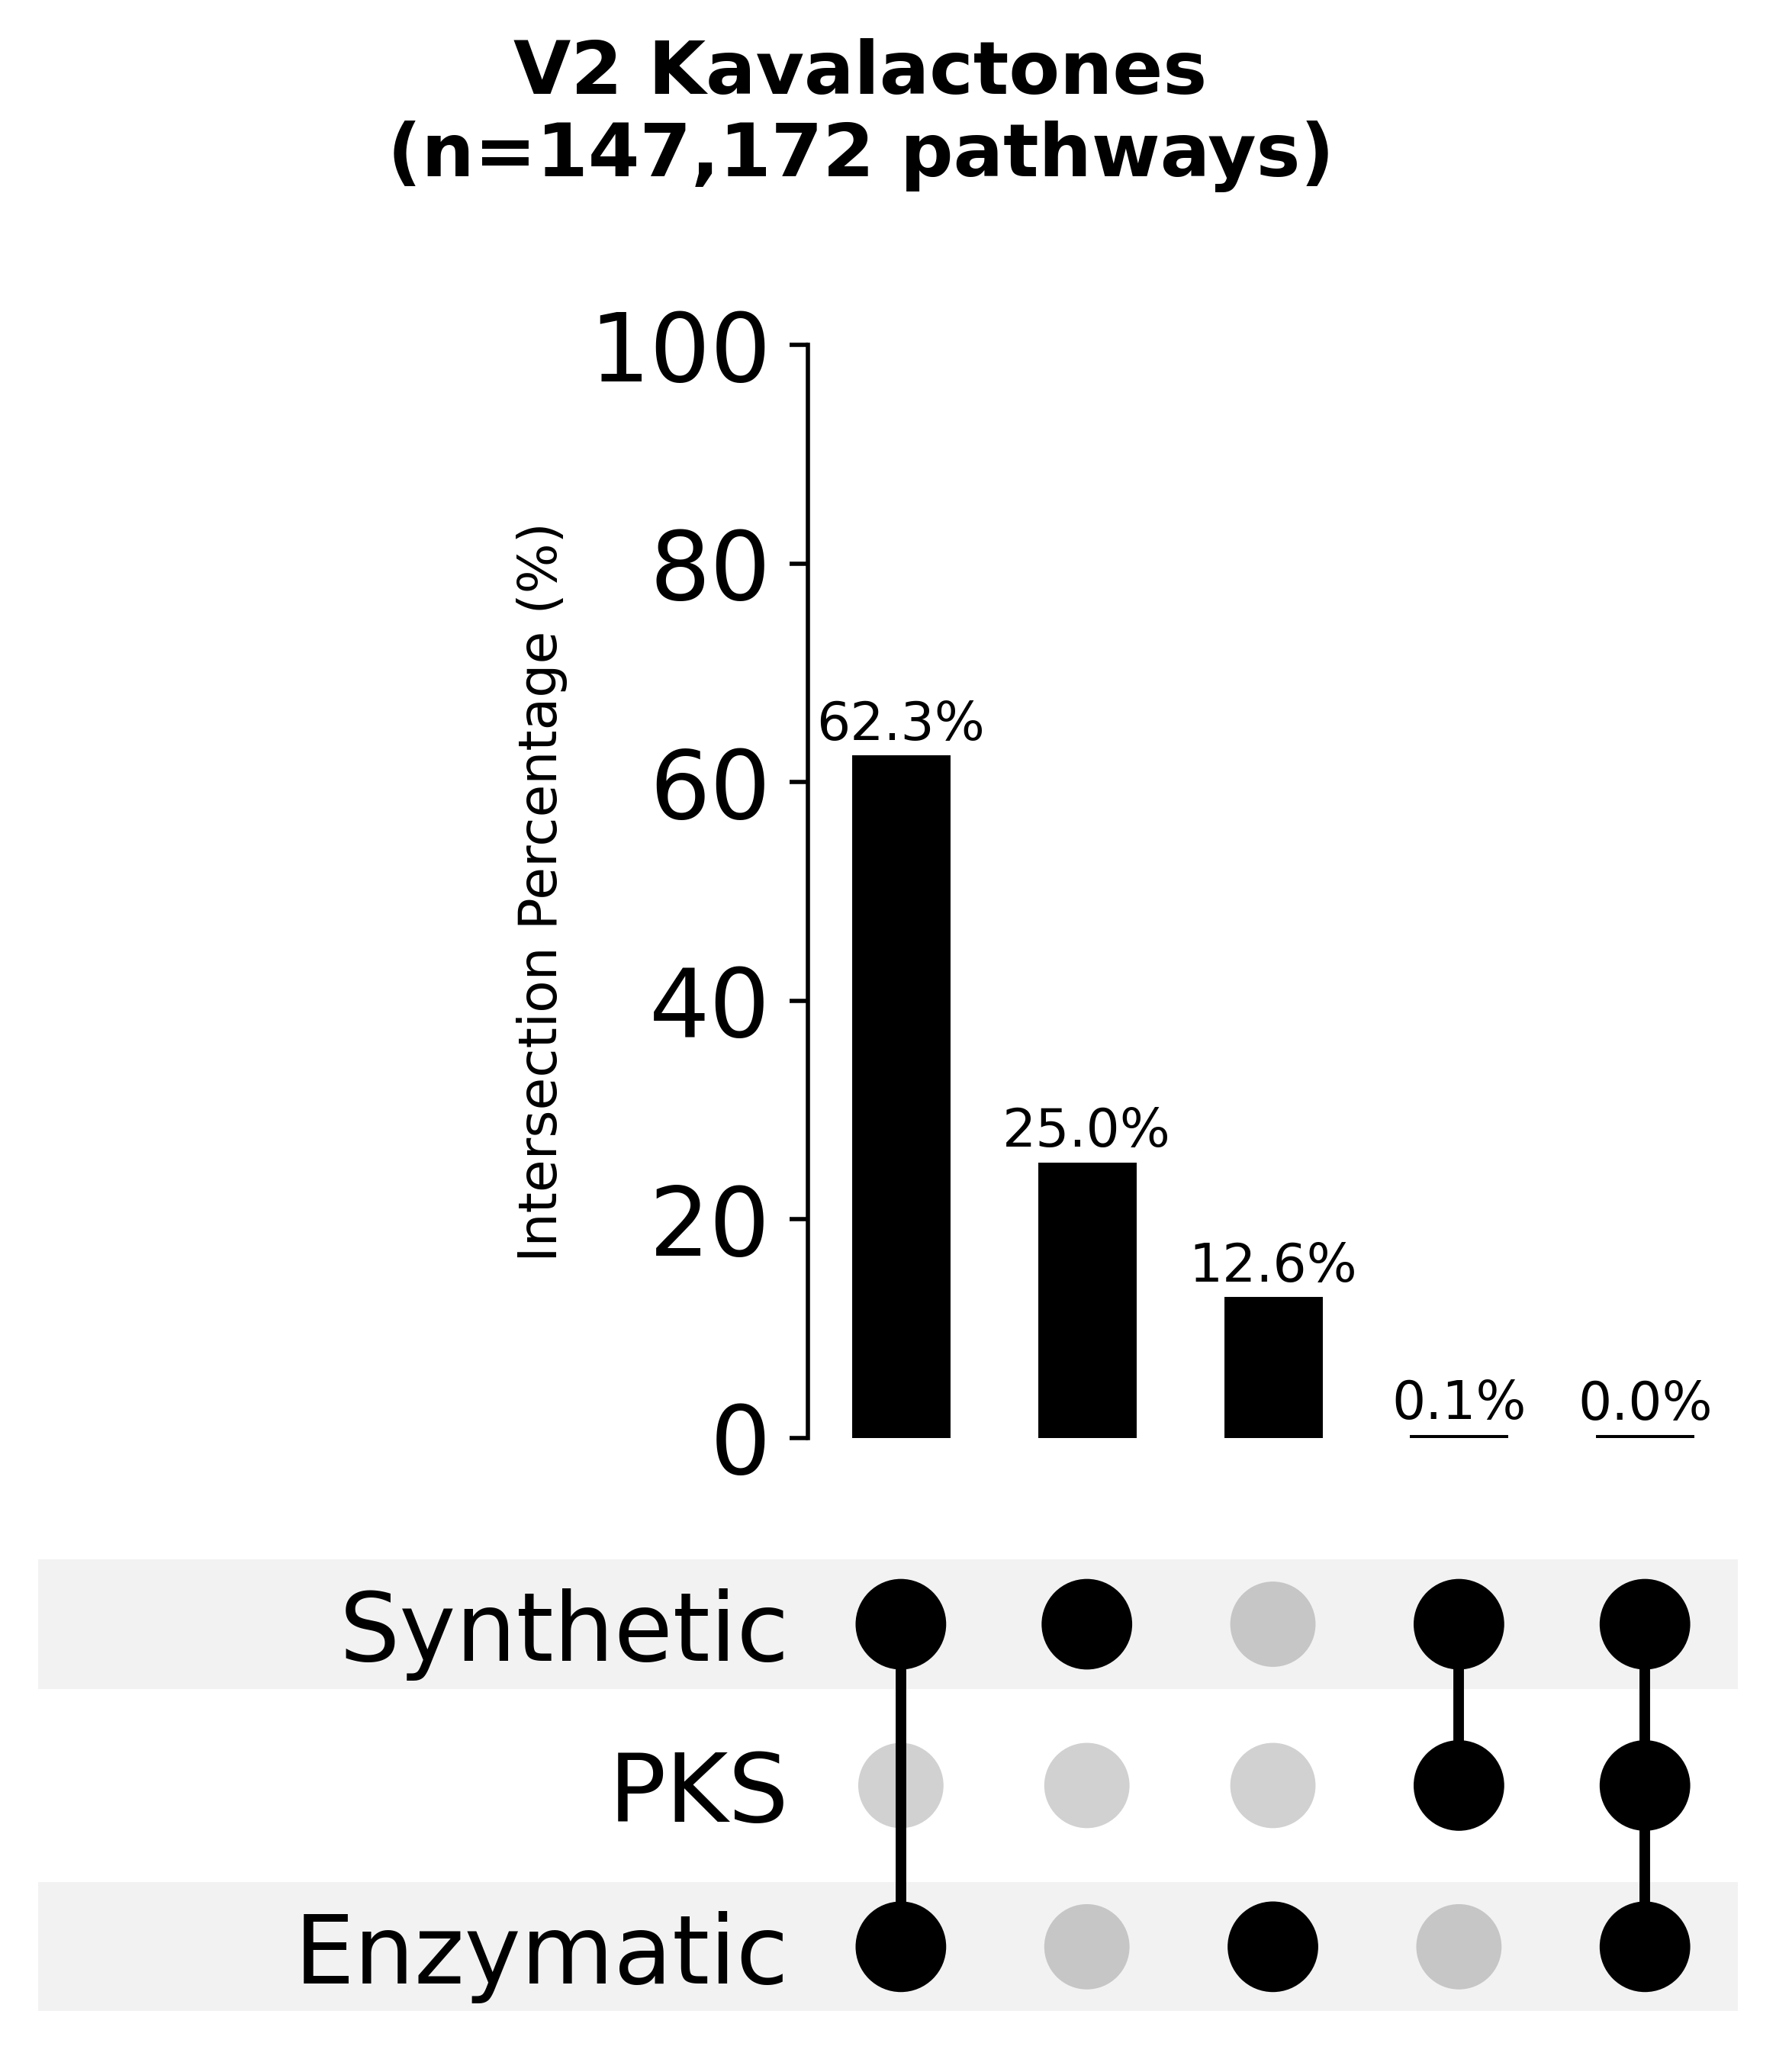


MODALITY COMBINATION PERCENTAGES (UpSet Plot Data)
  Enzymatic + Synthetic                   : 91,621 (62.25%)
  Synthetic                               : 36,796 (25.00%)
  Enzymatic                               : 18,617 (12.65%)
  PKS + Synthetic                         :    113 ( 0.08%)
  Enzymatic + PKS + Synthetic             :     25 ( 0.02%)


In [20]:
# Create UpSet plot for pathway modality combinations
# Install upsetplot if not available
try:
    from upsetplot import UpSet, from_memberships
except ImportError:
    import subprocess
    subprocess.check_call(['pip', 'install', 'upsetplot'])
    from upsetplot import UpSet, from_memberships

import warnings
import numpy as np
from collections import Counter

# Suppress FutureWarnings from upsetplot (pandas compatibility issues in the library)
warnings.filterwarnings('ignore', category=FutureWarning, module='upsetplot')

# Use tabulated counts for UpSet plot when available
total_pathways_for_upset = (enzymatic_only + synthetic_only + enzymatic_synthetic + 
                            pks_only + enzymatic_pks + synthetic_pks + all_three)

# Build combination data from tabulated counts
combination_counts = {}
if enzymatic_only > 0:
    combination_counts[('Enzymatic',)] = enzymatic_only
if synthetic_only > 0:
    combination_counts[('Synthetic',)] = synthetic_only
if enzymatic_synthetic > 0:
    combination_counts[('Enzymatic', 'Synthetic')] = enzymatic_synthetic
if pks_only > 0:
    combination_counts[('PKS',)] = pks_only
if enzymatic_pks > 0:
    combination_counts[('Enzymatic', 'PKS')] = enzymatic_pks
if synthetic_pks > 0:
    combination_counts[('PKS', 'Synthetic')] = synthetic_pks
if all_three > 0:
    combination_counts[('Enzymatic', 'PKS', 'Synthetic')] = all_three

print(f"Modality combinations found: {list(combination_counts.keys())}")

# Convert counts to percentages
combination_percentages = {}
for combo, count in combination_counts.items():
    combination_percentages[combo] = (count / total_pathways_for_upset) * 100 if total_pathways_for_upset > 0 else 0

# Create data for upsetplot with percentage values
memberships_for_plot = list(combination_percentages.keys())
pct_values = list(combination_percentages.values())

if memberships_for_plot:
    # Create Series with percentage values
    upset_pct_data = from_memberships(memberships_for_plot, data=pct_values)

    # Create the UpSet plot with percentages
    fig = plt.figure(figsize=(12, 8))
    upset = UpSet(
        upset_pct_data,
        subset_size='sum',  # Sum the percentage values
        show_counts='{:.1f}%',  # Format as percentage with 1 decimal place
        show_percentages=False,
        sort_by='cardinality',
        sort_categories_by=None,  # Keep categories in consistent order
        facecolor='black',
        element_size=46,
        totals_plot_elements=0  # Remove the horizontal bars showing totals per category
    )

    # Plot
    axes_dict = upset.plot(fig=fig)

    # Format the y-axis and remove grid lines
    intersections_ax = axes_dict['intersections']
    intersections_ax.set_ylabel('Intersection Percentage (%)')
    intersections_ax.set_ylim(0, 100)  # Set y-axis limits from 0 to 100
    intersections_ax.grid(False)  # Explicitly remove grid lines

    # Remove grid lines from all axes in the plot
    for ax_name, ax in axes_dict.items():
        if ax is not None:
            ax.grid(False)

    # Update the title dynamically based on the analysis
    plt.suptitle(f'{ANALYSIS_NAME}\n(n={total_pathways_for_upset:,} pathways)', 
                 fontsize=14, fontweight='bold', y=1.02)

    plt.tight_layout()

    # Save to figures/ folder with analysis-specific filename
    figures_dir = Path('../figures')
    figures_dir.mkdir(parents=True, exist_ok=True)  # Create figures folder if it doesn't exist

    upset_filename = RESULTS_SUBFOLDER.replace('_pathways', '').replace(' ', '_').lower()
    upset_path = figures_dir / f'{upset_filename}_upset_plot.png'
    plt.savefig(upset_path, dpi=300, bbox_inches='tight')
    print(f"UpSet plot saved to: {upset_path}")
    plt.show()
else:
    print("No modality combinations to plot")

# Print the percentage breakdown
print("\n" + "="*70)
print("MODALITY COMBINATION PERCENTAGES (UpSet Plot Data)")
print("="*70)

# Sort by count descending
sorted_combos = sorted(combination_counts.items(), key=lambda x: x[1], reverse=True)
for combo, count in sorted_combos:
    combo_str = " + ".join(combo)
    pct = 100 * count / total_pathways_for_upset if total_pathways_for_upset > 0 else 0
    print(f"  {combo_str:40s}: {count:6,} ({pct:5.2f}%)")